In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from analysis import get_feature_importances, visualize_decision_trees, get_vif, wl_accuracy, season_record, runs_per_game

In [20]:
version = 6
df = pd.read_csv(f'./data/baseball/training/game_data_v{version}.csv')

In [21]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
        # x_train, x_test = x.iloc[0:10617], x.iloc[10617:]
        # y_train, y_test = y.iloc[0:10617], y.iloc[10617:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [22]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(y_col='home_score', split_by='season')

In [18]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print('RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)')
print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(df, results)
print('-' * 30)
runs_per_game(df, results)

RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)
Accuracy: 52.8395061728395%
------------------------------
Season records:
STL: 94-68	DET: 93-69	ATL: 91-71	COL: 91-71	CHC: 87-75	
BOS: 85-77	AZ: 84-78	SD: 83-79	SF: 83-79	MIN: 83-79	
NYM: 82-80	LAA: 82-80	MIA: 82-80	TB: 82-80	MIL: 81-81	
CLE: 81-81	OAK: 81-81	CIN: 79-83	WSH: 79-83	KC: 79-83	
CWS: 79-83	HOU: 78-84	SEA: 77-85	TOR: 77-85	NYY: 76-86	
PIT: 75-87	BAL: 75-87	TEX: 75-87	LAD: 70-92	PHI: 66-96	
------------------------------
Runs scored per game:
NYY: 4.89 (793)	WSH: 4.86 (787)	MIA: 4.85 (786)	BOS: 4.83 (782)	ATL: 4.8 (778)	
STL: 4.8 (778)	CLE: 4.72 (765)	DET: 4.72 (765)	CWS: 4.7 (762)	MIN: 4.7 (762)	
AZ: 4.7 (761)	COL: 4.67 (756)	MIL: 4.66 (755)	LAA: 4.61 (747)	SF: 4.6 (746)	
CHC: 4.6 (746)	SD: 4.6 (746)	TEX: 4.59 (744)	KC: 4.59 (743)	OAK: 4.58 (741)	
NYM: 4.56 (738)	BAL: 4.56 (738)	TOR: 4.55 (738)	HOU: 4.54 (736)	TB: 4.51 (730)	
CIN: 4.49 (728)	SEA: 4.49 (728)	PIT: 4.38 (709)	LAD: 4.35 (704)	PHI: 4.25 (689)	


By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy. Looking at the histogram below, we can see that this modified version has a mean accuracy of about 53%, which is still better than a random guessing model.

                0
count  100.000000
mean    53.105761
std      0.970646
min     50.082305
25%     52.335391
50%     53.148148
75%     53.827160
max     55.144033


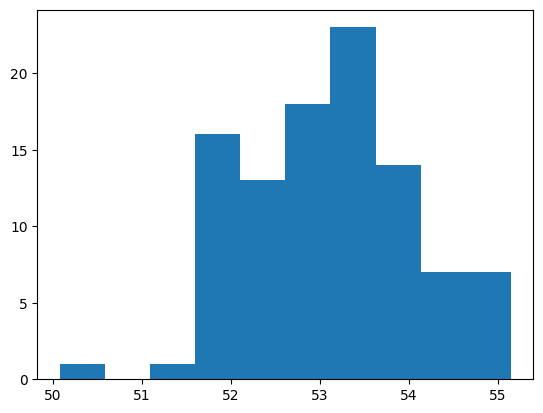

In [19]:
acc = []

for i in range(100):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)
    
    results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
    results.describe()
    
    acc.append(wl_accuracy(results))


print(pd.DataFrame(acc).describe())

plt.hist(acc)
plt.show()

In [ ]:
# visualize_decision_trees(model_home, x_test_home.columns)